# 1. Psychometric Fitting

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.optimize import curve_fit
from scipy.stats import norm
from sklearn.metrics import mean_squared_error
from scipy import stats
from pingouin import rm_anova
import seaborn as sns

In [3]:
import warnings
from scipy.optimize import OptimizeWarning

warnings.simplefilter('ignore', OptimizeWarning)
warnings.simplefilter('ignore', RuntimeWarning)

In [4]:
# Load the data
data = pd.read_csv("data.csv")
subjects = pd.read_csv("subjectInfo.csv")

data

,trialKeys,levelFreq,levelFace,lCueName,rCueName,srespLoc,srespChoice,RT,Hand,blockType,subjectId
0,AbHa,LF,1,Hasan,Abbas,right,Abbas,0.672450,Left,same,sub1
1,MahGol,LF,3,Goli,Mahnaz,right,Mahnaz,2.157862,Left,same,sub1
2,AbHa,LF,-3,Hasan,Abbas,right,Abbas,1.110335,Left,same,sub1
3,AbHa,LF,0,Hasan,Abbas,right,Abbas,0.676922,Left,same,sub1
4,MahGol,LF,0,Goli,Mahnaz,right,Mahnaz,0.970347,Left,same,sub1
...,...,...,...,...,...,...,...,...,...,...,...
51067,MahGol,LF,-1,Mahnaz,Goli,left,Mahnaz,1.531718,Right,mix,sub38
51068,AbHa,HF,-1,Abbas,Hasan,right,Hasan,0.985676,Right,mix,sub38
51069,AbHa,IF,-2,Abbas,Hasan,left,Abbas,1.299862,Right,mix,sub38
51070,MahGol,IF,-3,Mahnaz,Goli,left,Mahnaz,2.106708,Right,mix,sub38


In [5]:
# Check for missing values
print("Missing values in data:")
print(data.isna().sum())

data = data.dropna()

Missing values in data:
trialKeys        0
levelFreq        0
levelFace        0
lCueName         0
rCueName         0
srespLoc       548
srespChoice    548
RT             548
Hand             0
blockType        0
subjectId        0
dtype: int64


## 1.1 Compare Models (generalized sigmoid vs. Gaussian CDF)

In [6]:
# Define models
def sigmoid(x, alpha, beta):
    return alpha / (1 + np.exp(-beta * x))

def generalized_sigmoid(x, alpha, beta, y, lambd):
    return alpha / (1 + np.exp(-beta * (x - y))) + lambd

def gaussian_cdf(x, alpha, mu, sigma):
    return alpha * norm.cdf(x, mu, sigma)

In [7]:
# AIC calculation
def aic(n, mse, k):
    return n * np.log(mse) + 2 * k

# BIC calculation
def bic(n, mse, k):
    return n * np.log(mse) + k * np.log(n)

In [8]:
def fit_model(x, y, model_func=sigmoid, p0=[1.0, 1.0]):
    popt, _ = curve_fit(model_func, x, y, p0=p0, maxfev=1000000)
    return popt

In [9]:
def count_and_scatter(data, pair, type, freq):
    subset = data[(data['trialKeys'] == pair) & (data['blockType'] == type) & (data['levelFreq'] == freq)]

    proportions = subset.groupby('levelFace')['srespChoice'].apply(lambda x: np.mean(
        x.isin(['Hasan', 'Goli']))).reset_index(name='proportion')
    
    x = proportions['levelFace']
    y = proportions['proportion']

    plt.scatter(x, y)
    plt.xlabel('Morph Level')
    plt.ylabel('Proportion Choice')
    plt.grid()

    return x, y

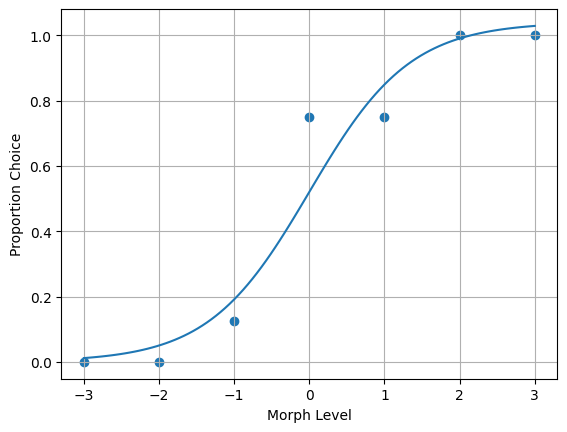

In [10]:
sub1_data = data[data['subjectId'] == 'sub1']
x, y = count_and_scatter(sub1_data, 'MahGol', 'same', 'IF')

popt = fit_model(x, y)
x_values = np.linspace(min(x), max(x), 100)
plt.plot(x_values, sigmoid(x_values, *popt))
plt.savefig("fitted_sigmoid_1.pdf")

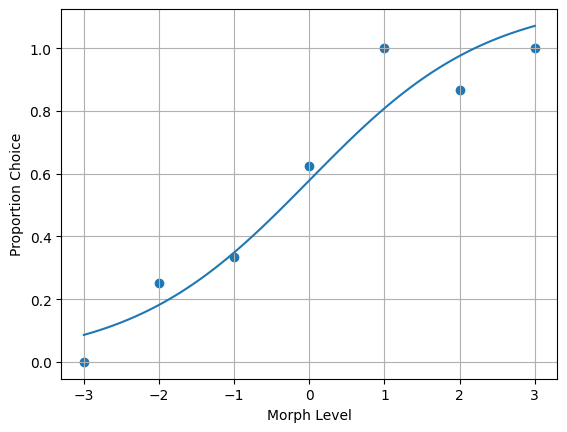

In [11]:
sub4_data = data[data['subjectId'] == 'sub4']
x, y = count_and_scatter(sub4_data, 'AbHa', 'mix', 'LF')

popt = fit_model(x, y)
x_values = np.linspace(min(x), max(x), 100)
plt.plot(x_values, sigmoid(x_values, *popt))
plt.savefig("fitted_sigmoid_2.pdf")

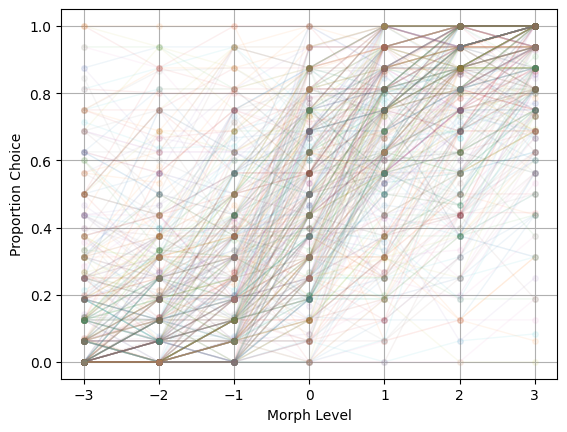

In [12]:
models = [
    (generalized_sigmoid, [1.0, 1.0, 0.0, 0.0], 4),
    (gaussian_cdf, [1.0, 0.0, 1.0], 3)
]

scores = defaultdict(list)

# Run for each subject and each condition
for sid in data['subjectId'].unique():
    sub_data = data[data['subjectId'] == sid]

    for pair in sub_data['trialKeys'].unique():
        for type in sub_data['blockType'].unique():
            for freq in sub_data['levelFreq'].unique():

                subset = sub_data[(sub_data['trialKeys'] == pair) & (sub_data['blockType'] == type) & (sub_data['levelFreq'] == freq)]

                proportions = subset.groupby('levelFace')['srespChoice'].apply(lambda x: np.mean(
                    x.isin(['Hasan', 'Goli']))).reset_index(name='proportion')

                x = proportions['levelFace']
                y = proportions['proportion']
                n = len(x)

                for func, p0, k in models:
                    popt = fit_model(x, y, func, p0)
                    y_fit = func(x, *popt)
                    mse = mean_squared_error(y, y_fit)
                    
                    aic_score = aic(n, mse, k)
                    bic_score = bic(n, mse, k)

                    scores[(func.__name__, 'aic')].append(aic_score)
                    scores[(func.__name__, 'bic')].append(bic_score)

                plt.plot(x, y, marker='o', markersize=4, linewidth=1, alpha=0.07)

plt.xlabel('Morph Level')
plt.ylabel('Proportion Choice')
plt.grid()
plt.savefig("total_scatter.pdf")

In [13]:
scores = pd.DataFrame(scores)
scores

generalized_sigmoid            gaussian_cdf           
                    aic        bic          aic        bic
0            -49.862783 -50.079142   -38.429481 -38.591750
1            -25.575223 -25.791582   -20.230398 -20.392668
2            -40.767510 -40.983869   -40.061462 -40.223731
3            -29.552406 -29.768766   -28.614661 -28.776931
4            -30.570603 -30.786962   -30.762426 -30.924696
..                  ...        ...          ...        ...
451          -30.940318 -31.156677   -32.860290 -33.022560
452          -31.157773 -31.374132   -26.483736 -26.646006
453          -32.897003 -33.113362   -25.708843 -25.871113
454          -26.557352 -26.773711   -27.014147 -27.176417
455          -35.886616 -36.102976   -35.413274 -35.575543

[456 rows x 4 columns]

In [14]:
scores.mean()

generalized_sigmoid  aic   -37.842902
                     bic   -38.059261
gaussian_cdf         aic   -38.302336
                     bic   -38.464606
dtype: float64

In [15]:
# Determine which model is better for each trial
scores['aic_better'] = np.where(
    scores['generalized_sigmoid']['aic'] < scores['gaussian_cdf']['aic'], 
    'Sigmoid', 
    'Gaussian'
)
scores['bic_better'] = np.where(
    scores['generalized_sigmoid']['bic'] < scores['gaussian_cdf']['bic'], 
    'Sigmoid', 
    'Gaussian'
)

# Count model preferences
aic_counts = scores['aic_better'].value_counts()
bic_counts = scores['bic_better'].value_counts()

print("AIC Preferences:\n", aic_counts)
print("\nBIC Preferences:\n", bic_counts)

AIC Preferences:
 aic_better
Gaussian    275
Sigmoid     181
Name: count, dtype: int64

BIC Preferences:
 bic_better
Gaussian    274
Sigmoid     182
Name: count, dtype: int64


In [16]:
# Paired t-tests
aic_ttest = stats.ttest_rel(scores['generalized_sigmoid']['aic'], scores['gaussian_cdf']['aic'])
bic_ttest = stats.ttest_rel(scores['generalized_sigmoid']['bic'], scores['gaussian_cdf']['bic'])

# Wilcoxon signed-rank tests (non-parametric alternative)
aic_wilcoxon = stats.wilcoxon(scores['gaussian_cdf']['aic'], scores['generalized_sigmoid']['aic'])
bic_wilcoxon = stats.wilcoxon(scores['gaussian_cdf']['bic'], scores['generalized_sigmoid']['bic'])

print(f"AIC t-test: t = {aic_ttest.statistic:.3f}, p = {aic_ttest.pvalue:.4f}")
print(f"BIC t-test: t = {bic_ttest.statistic:.3f}, p = {bic_ttest.pvalue:.4f}")
print(f"AIC Wilcoxon: W = {aic_wilcoxon.statistic:.3f}, p = {aic_wilcoxon.pvalue:.4f}")
print(f"BIC Wilcoxon: W = {bic_wilcoxon.statistic:.3f}, p = {bic_wilcoxon.pvalue:.4f}")

AIC t-test: t = 0.786, p = 0.4322
BIC t-test: t = 0.694, p = 0.4883
AIC Wilcoxon: W = 47857.000, p = 0.1320
BIC Wilcoxon: W = 48724.000, p = 0.2308


## 1.2 Hypothesis Testing

In [17]:
# Filter only 'same' blockType
data_same = data[data['blockType'] == 'same']

In [18]:
def fit_psychometric(data, model_func=sigmoid, p0=[1.0, 1.0]):
    proportions = data.groupby('levelFace')['srespChoice'].apply(lambda x: np.mean(
        x.isin(['Hasan', 'Goli']))).reset_index(name='proportion')
    
    x = proportions['levelFace'].values
    y = proportions['proportion'].values

    return fit_model(x, y, model_func, p0)

In [19]:
# Run for each subject and each condition
def calculate_beta(data, cond_key=None):
    betas_dict = defaultdict(list)

    for sid in data['subjectId'].unique():
        sub_data = data[data['subjectId'] == sid]
        betas_dict[('subjectId', '') if cond_key else 'subjectId'].append(sid)

        for pair in sub_data['trialKeys'].unique():
            if cond_key is None:
                subset = sub_data[sub_data['trialKeys'] == pair]
                _, beta = fit_psychometric(subset)
                betas_dict[pair].append(beta)
            else:
                for cond_value in data[cond_key].unique():
                    subset = sub_data[(sub_data['trialKeys'] == pair) & (sub_data[cond_key] == cond_value)]
                    _, beta = fit_psychometric(subset)
                    betas_dict[(pair, cond_value)].append(beta)
                    
    return pd.DataFrame(betas_dict)

In [20]:
def stat_test(data, parametric_test, nonparametric_test, alternative=None, alpha=0.05):
    # Normality check
    p_normal = all(stats.shapiro(group)[1] >= alpha for group in data)
    
    # Choose test based on normality
    if p_normal >= alpha:
        test_name = parametric_test.__name__
        test = parametric_test
    else:
        test_name = nonparametric_test.__name__
        test = nonparametric_test
    
    if alternative:
        result = test(*data, alternative=alternative)
    else:
        result = test(*data)
        
    print(f"{test_name}: statistic = {result.statistic:.1f}, p-value = {result.pvalue:.4f}")

In [ ]:
def plot_violin(data, xlabel, name):
    sns.violinplot(data=data)
    plt.xlabel(xlabel)
    plt.ylabel('Beta')
    plt.title(name)
    plt.savefig(f"Beta violin_plot {xlabel}.pdf", bbox_inches="tight", dpi=300, metadata={'Date': None})

### 1.2.1. Whether sensitivity to detecting identity from different spatial frequency bands differs.

AbHa friedmanchisquare: statistic = 13.0, p-value = 0.0015
MahGol friedmanchisquare: statistic = 45.8, p-value = 0.0000


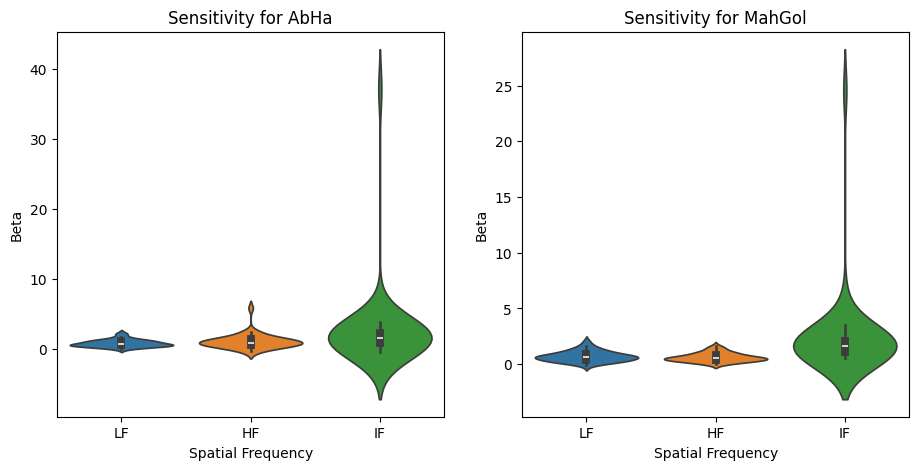

In [22]:
pivot_freq = calculate_beta(data_same, 'levelFreq')

plt.figure(figsize=(11, 5))
for i, pair in enumerate(['AbHa', 'MahGol']):
    print(pair, end=' ')
    stat_test(pivot_freq[pair].values.T, rm_anova, stats.friedmanchisquare)
    plt.subplot(1, 2, i + 1)
    plot_violin(pivot_freq[pair], "Spatial Frequency", f"Sensitivity for {pair}")

AbHa IF vs LF wilcoxon: statistic = 95.0, p-value = 0.0000
AbHa IF vs HF wilcoxon: statistic = 204.0, p-value = 0.0148
AbHa LF vs HF wilcoxon: statistic = 293.0, p-value = 0.2675
MahGol IF vs LF wilcoxon: statistic = 1.0, p-value = 0.0000
MahGol IF vs HF wilcoxon: statistic = 11.0, p-value = 0.0000
MahGol LF vs HF ttest_rel: statistic = 1.0, p-value = 0.3185


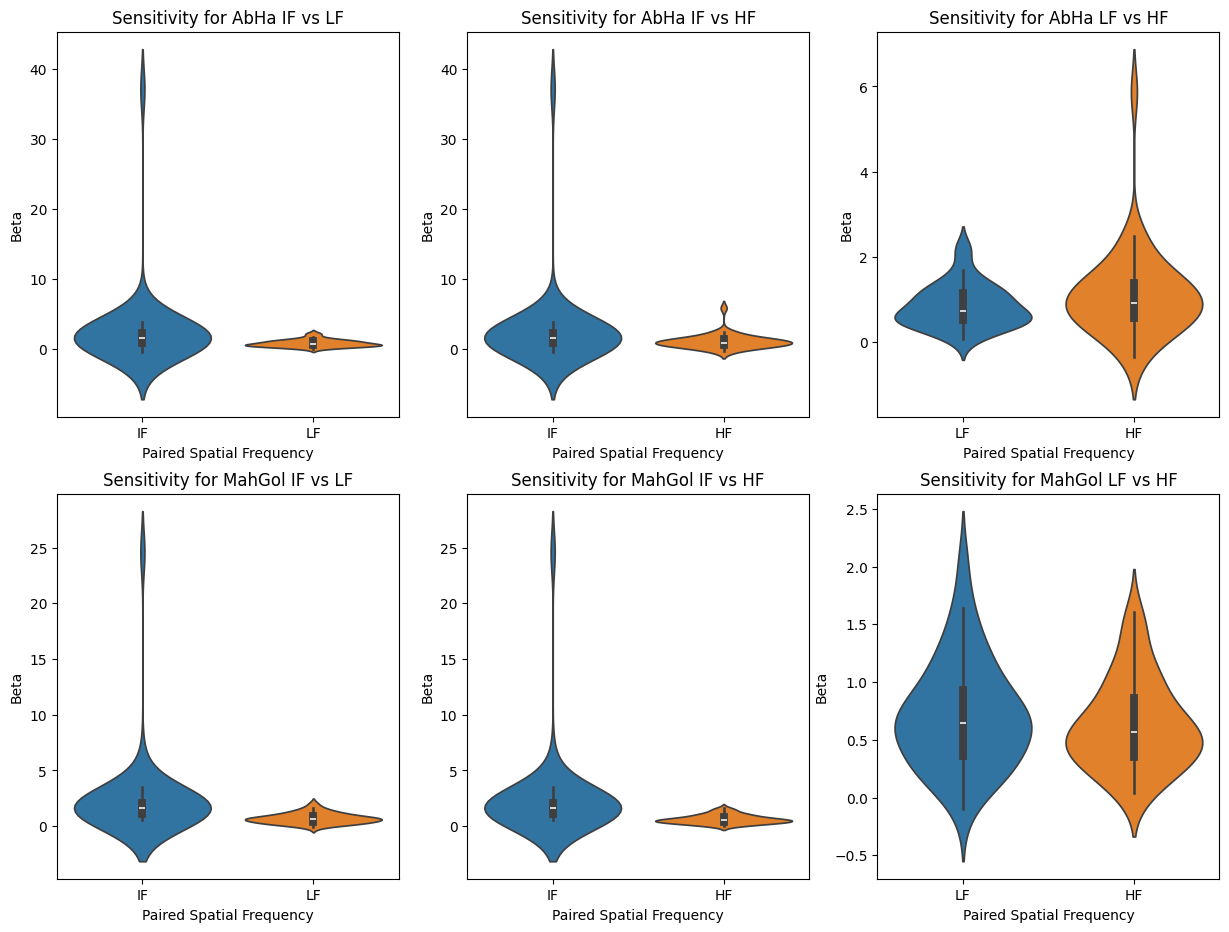

In [23]:
plt.figure(figsize=(15, 11))
for i, pair in enumerate(['AbHa', 'MahGol']):
    print(f'{pair} IF vs LF', end=' ')
    stat_test(pivot_freq[pair][['IF', 'LF']].values.T, stats.ttest_rel, stats.wilcoxon)
    print(f'{pair} IF vs HF', end=' ')
    stat_test(pivot_freq[pair][['IF', 'HF']].values.T, stats.ttest_rel, stats.wilcoxon)
    print(f'{pair} LF vs HF', end=' ')
    stat_test(pivot_freq[pair][['LF', 'HF']].values.T, stats.ttest_rel, stats.wilcoxon)

    plt.subplot(2, 3, 3 * i + 1)
    plot_violin(pivot_freq[pair][['IF', 'LF']], "Paired Spatial Frequency", f"Sensitivity for {pair} IF vs LF")
    plt.subplot(2, 3, 3 * i + 2)
    plot_violin(pivot_freq[pair][['IF', 'HF']], "Paired Spatial Frequency", f"Sensitivity for {pair} IF vs HF")
    plt.subplot(2, 3, 3 * i + 3)
    plot_violin(pivot_freq[pair][['LF', 'HF']], "Paired Spatial Frequency", f"Sensitivity for {pair} LF vs HF")

### 1.2.2 Whether people are more adept at identifying images of their conspecific or hetero-specific gender.

AbHa ttest_ind: statistic = -1.0, p-value = 0.3069
MahGol ttest_ind: statistic = 0.5, p-value = 0.5933


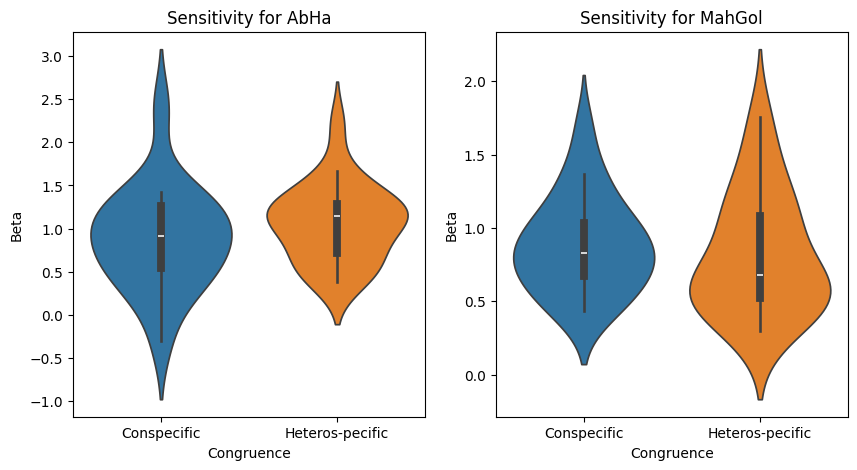

In [24]:
pivot_key = calculate_beta(data_same)

plt.figure(figsize=(10, 5))
for i, pair in enumerate(['AbHa', 'MahGol']):
    pair_sex = 'M' if pair == 'AbHa' else 'F'
    conspecifics_beta = pivot_key[pair][subjects['sex'] == pair_sex].rename('Conspecific')
    hetro_specific_betas = pivot_key[pair][subjects['sex'] != pair_sex].rename('Heteros-pecific')
    pivot_congruence = [conspecifics_beta, hetro_specific_betas]

    print(pair, end=' ')
    stat_test(pivot_congruence, stats.ttest_ind, stats.mannwhitneyu)

    plt.subplot(1, 2, i + 1)
    plot_violin(pivot_congruence, "Congruence", f"Sensitivity for {pair}")

### 1.2.3. Whether subjects can better detect identities in a specific spectral band if they use their left hand.

Hand Sensitivity for IF
	AbHa wilcoxon: statistic = 458.0, p-value = 0.1048
	MahGol wilcoxon: statistic = 397.0, p-value = 0.3546
Hand Sensitivity for LF
	AbHa wilcoxon: statistic = 375.0, p-value = 0.4771
	MahGol wilcoxon: statistic = 362.0, p-value = 0.5513
Hand Sensitivity for HF
	AbHa wilcoxon: statistic = 413.0, p-value = 0.2733
	MahGol wilcoxon: statistic = 281.0, p-value = 0.9029


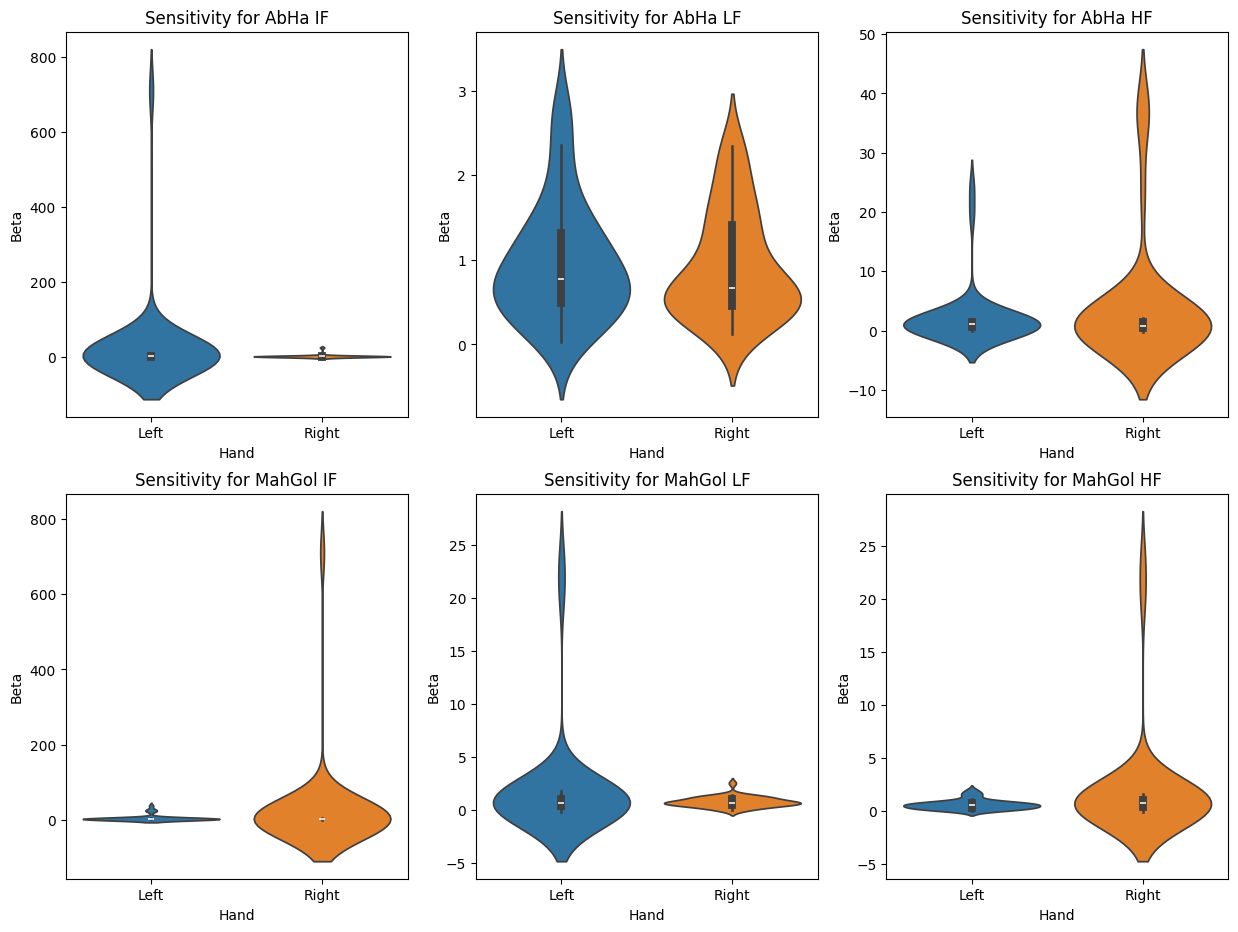

In [25]:
plt.figure(figsize=(15, 11))
for i, freq in enumerate(['IF', 'LF', 'HF']):
    print(f"Hand Sensitivity for {freq}")
    pivot_hand = calculate_beta(data_same[data_same['levelFreq'] == freq], 'Hand')

    for j, pair in enumerate(['AbHa', 'MahGol']):
        print(f'\t{pair}', end=' ')
        stat_test(pivot_hand[pair].values.T, stats.ttest_rel, stats.wilcoxon, alternative='greater')
        plt.subplot(2, 3, j * 3 + i + 1)
        plot_violin(pivot_hand[pair], "Hand", f"Sensitivity for {pair} {freq}")

### 1.2.4. Whether subjects can better detect identities in a specific spectral band if they use their dominant hand.

Dominance Sensitivity for IF
	AbHa wilcoxon: statistic = 308.0, p-value = 0.8175
	MahGol wilcoxon: statistic = 380.0, p-value = 0.4487
Dominance Sensitivity for LF
	AbHa wilcoxon: statistic = 330.0, p-value = 0.7219
	MahGol wilcoxon: statistic = 392.0, p-value = 0.3817
Dominance Sensitivity for HF
	AbHa wilcoxon: statistic = 351.0, p-value = 0.6128
	MahGol wilcoxon: statistic = 427.0, p-value = 0.2105


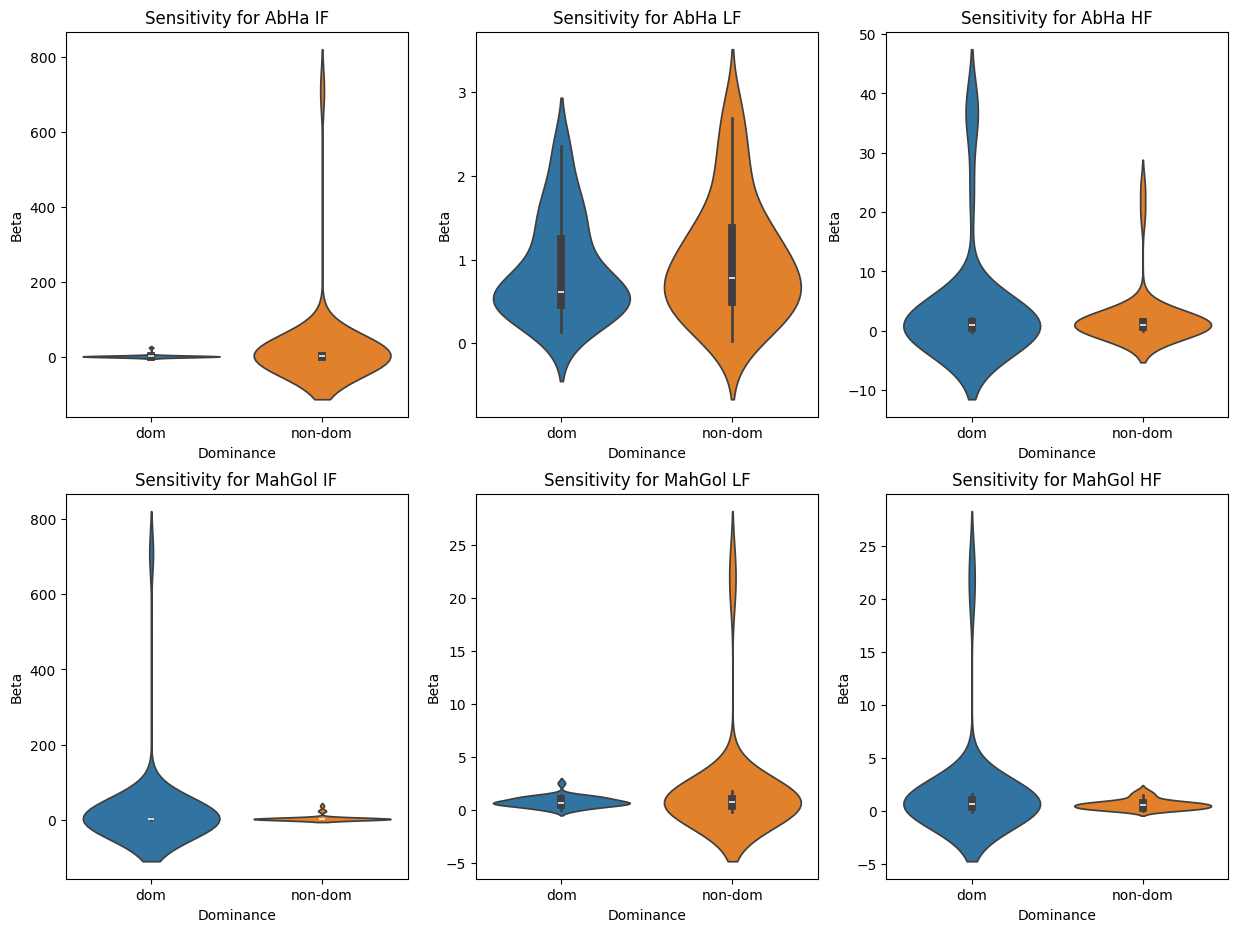

In [26]:
plt.figure(figsize=(15, 11))
for i, freq in enumerate(['IF', 'LF', 'HF']):
    print(f"Dominance Sensitivity for {freq}")
    pivot_hand = calculate_beta(data_same[data_same['levelFreq'] == freq], 'Hand')
    
    for j, pair in enumerate(['AbHa', 'MahGol']):
        pivot_dom = pd.DataFrame([{
                'dom': row['Right'] if row['dom'] == 'R' else row['Left'], 
                'non-dom': row['Left'] if row['dom'] == 'R' else row['Right']
            } for i, row in pivot_hand[pair].assign(dom=subjects['dom']).iterrows()])

        print(f'\t{pair}', end=' ')
        stat_test(pivot_dom[['dom', 'non-dom']].values.T, stats.ttest_rel, stats.wilcoxon, alternative='greater')
        plt.subplot(2, 3, j * 3 + i + 1)
        plot_violin(pivot_dom[['dom', 'non-dom']], "Dominance", f"Sensitivity for {pair} {freq}")

### 1.2.5. Whether women are significantly better than men in the task of identity detection.

AbHa ttest_ind: statistic = -0.9, p-value = 0.1777
MahGol ttest_ind: statistic = -0.9, p-value = 0.1903


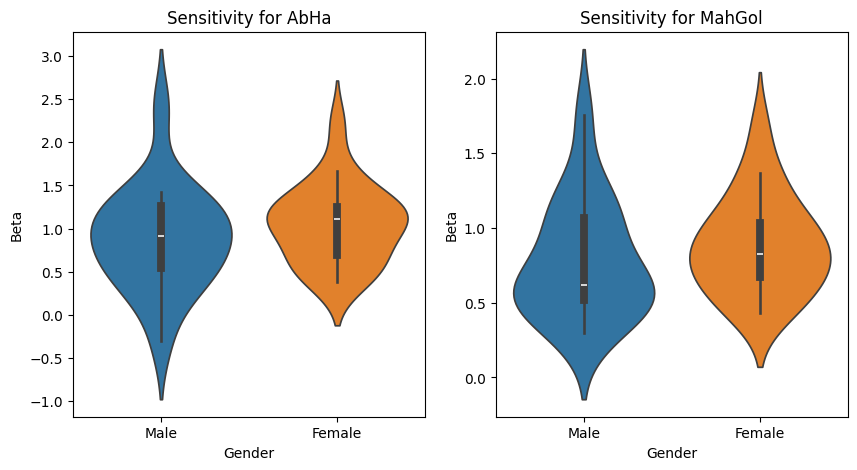

In [27]:
pivot_key = calculate_beta(data_same)

plt.figure(figsize=(10, 5))
for i, pair in enumerate(['AbHa', 'MahGol']):
    male_beta = pivot_key[pair][subjects['sex'] == 'M'].rename('Male')
    female_beta = pivot_key[pair][subjects['sex'] == 'F'].rename('Female')
    pivot_gender = [male_beta, female_beta]

    print(f"{pair}", end=' ')
    stat_test(pivot_gender, stats.ttest_ind, stats.mannwhitneyu, alternative='less')
    plt.subplot(1, 2, i + 1)
    plot_violin(pivot_gender, 'Gender', f"Sensitivity for {pair}")